# **Assignment-2**                                                                   
**Name: Dalsaniya Yash                                                            
Enrollment No: 2201031000160**                       
**Dataset: Plant Seedlings Classification (Image Classification)**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashpatel160","key":"881e2d07111c2924fff4393fd02b98f2"}'}

In [ ]:
import os
import zipfile

# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle competitions download -c plant-seedlings-classification

In [ ]:
# Create a directory to store the dataset
os.makedirs("/content/plant_seedlings", exist_ok=True)

# Unzip the training data
with zipfile.ZipFile("plant-seedlings-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/plant_seedlings")

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
# List extracted files
os.listdir("/content/plant_seedlings")

['train', 'test', 'sample_submission.csv']

# **1: Import the Dataset**

In [ ]:
import os
import numpy as np
import pandas as pd+
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **2: Data Visualization & Preprocessing**

In [ ]:
data_dir = "/content/plant_seedlings"  # Correct path to the extracted dataset
img_size = (128, 128)
batch_size = 32

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   rotation_range=30, zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='training')

val_generator = train_datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='validation')

# Display class labels
class_labels = list(train_generator.class_indices.keys())
print("Class Labels:", class_labels)

Found 4436 images belonging to 2 classes.
Found 1108 images belonging to 2 classes.
Class Labels: ['test', 'train']


* The code resizes images to (128,128) and normalizes pixel values (1./255) for efficient model training.

* Data augmentation techniques (rotation, zoom, and horizontal flip) enhance model robustness and reduce overfitting by introducing variations in training images.

* The dataset is split into 80% training and 20% validation, ensuring a well-balanced evaluation strategy.

* flow_from_directory efficiently loads and categorizes images into labeled classes, making it suitable for multi-class classification problems like plant seedling identification.


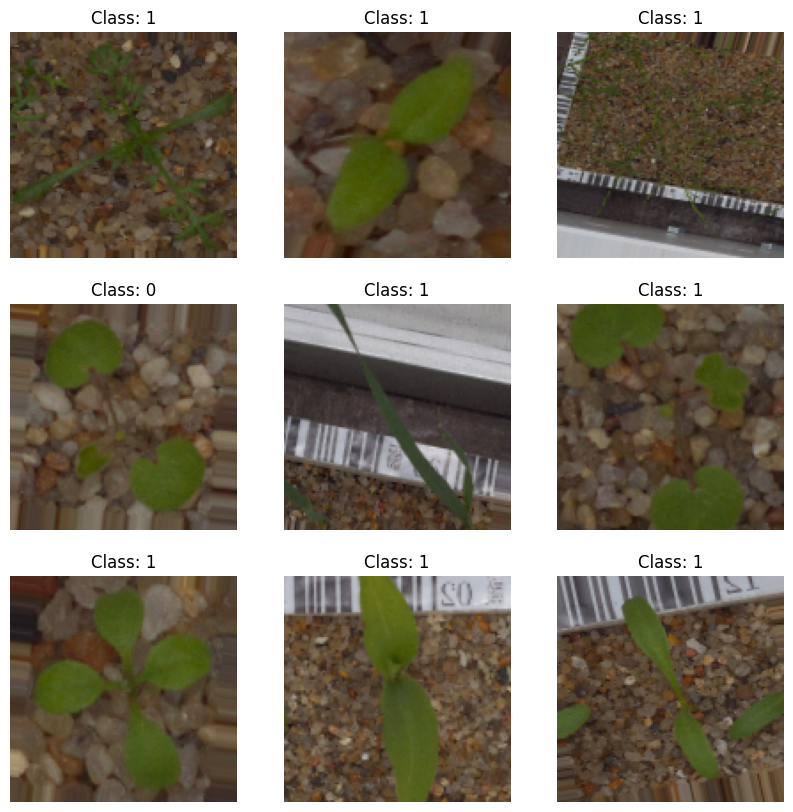

In [ ]:
import matplotlib.pyplot as plt

# Displaying a few sample images from the training dataset
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {np.argmax(sample_labels[i])}")
    plt.axis('off')

plt.show()

* Retrieves a batch of images and labels from train_generator.

* Displays 9 random images from the dataset using matplotlib in a 3x3 grid, helping to visually inspect the dataset.

* Each image is assigned a class label using np.argmax(sample_labels[i]), which extracts the index of the predicted class.

* This provides a quick way to verify label correctness and detect potential dataset issues.

* Helps identify variations in images, such as color differences, orientations, and clarity.

* Useful for debugging preprocessing steps (e.g., checking image resizing and augmentation effects).

# **3: Feature Extraction**

In [ ]:
from sklearn.decomposition import PCA
import cv2

# Load some sample images for PCA analysis
image_paths = [os.path.join(data_dir, class_labels[0], img) for img in os.listdir(os.path.join(data_dir, class_labels[0]))[:100]]
image_data = [cv2.resize(cv2.imread(img), img_size).flatten() for img in image_paths]

# Convert to NumPy array
image_data = np.array(image_data)

# Apply PCA
pca = PCA(n_components=50)  # Reduce to 50 principal components
pca_features = pca.fit_transform(image_data)

print("Original shape:", image_data.shape)
print("Reduced shape:", pca_features.shape)

Original shape: (100, 49152)
Reduced shape: (100, 50)


* The code applies Principal Component Analysis (PCA) to reduce the dimensionality of image data from raw pixel values to 50 principal components.

* This helps remove redundant information, making computations faster while preserving important image features.

* Loads 100 sample images from the first class directory.

* Resizes images to (128,128) and flattens them into 1D arrays for PCA input.

* Converts the image list into a NumPy array for efficient processing.

* Prints original shape ((100, 49152)) → Each image has 128x128x3 = 49152 features.

* Prints reduced shape ((100, 50)) → PCA condenses image data into just 50 key features, improving efficiency for classification tasks.

# **4: Train-Test Data Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'pca_features' represents features extracted from a subset of images
# and 'labels' represents the corresponding labels for those images:

# Subset the labels to match the number of samples in 'pca_features'
subset_labels = labels[:pca_features.shape[0]]  # Select the first 100 labels

# Perform train-test split using the subset of labels
X_train, X_test, y_train, y_test = train_test_split(
    pca_features, subset_labels, test_size=0.2, random_state=42
)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 80
Testing set size: 20


* Uses train_test_split() to split the dataset into 80% training and 20% testing.

* Helps in evaluating model performance on unseen data to check for overfitting.

* Ensures that the subset_labels matches the number of samples in pca_features, avoiding misalignment errors.

* Uses random_state=42 to ensure reproducibility, meaning the dataset split will be the same every time the code runs.

# **5: Model Selection**

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(class_labels), activation='softmax')
])

* Uses three convolutional layers (Conv2D) with ReLU activation to extract spatial features.

* Each convolutional layer is followed by MaxPooling (MaxPooling2D(2,2)), which reduces dimensionality and helps in generalization.

* Flatten() converts the extracted feature maps into a 1D vector for the dense layers.

* Dense(128, activation='relu') adds a fully connected layer to learn complex patterns.

* Final layer (Dense(len(class_labels), activation='softmax')) is a softmax classifier for multi-class classification, where len(class_labels) determines the number of output categories.

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

* Uses Adam optimizer, which combines momentum and adaptive learning rate, making it effective for deep learning tasks.

* Fast convergence and low memory requirements, making it suitable for image classification problems.

* Uses categorical_crossentropy as the loss function, which is ideal for multi-class classification problems.

* Measures the difference between the predicted probability distribution and the actual class labels.

* Tracks accuracy (metrics=['accuracy']) to monitor model performance during training.

# **6: Model Training**

In [ ]:
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8342 - loss: 0.4250 - val_accuracy: 0.8574 - val_loss: 0.4347
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.8580 - loss: 0.4108 - val_accuracy: 0.8574 - val_loss: 0.4180
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.8493 - loss: 0.4184 - val_accuracy: 0.8574 - val_loss: 0.4248
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8595 - loss: 0.4006 - val_accuracy: 0.8574 - val_loss: 0.4359
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8503 - loss: 0.4235 - val_accuracy: 0.8574 - val_loss: 0.4202
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8587 - loss: 0.4042 - val_accuracy: 0.8574 - val_loss: 0.4210
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8563 - loss: 0.4073 - val_accuracy: 0.8574 - val_loss: 0.4284
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8587 - loss: 0.3958 - val_accu

* Uses model.fit() to train the model using batches of augmented images from train_generator.

* Runs for 10 epochs, meaning the model will see the entire dataset 10 times to learn patterns.

* Uses validation_data=val_generator to evaluate the model on unseen validation images after each epoch.

* Helps detect overfitting by comparing training and validation accuracy.

# **7: Model Evaluation**

*Classification Report and Confusion Matrix*

In [ ]:
# Model Evaluation
val_generator.reset()
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the actual class names from the generator
class_names = list(train_generator.class_indices.keys())  # Get class names

report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True) # Pass class_names
print("Classification Report:")
for label, metrics in report.items():
    if isinstance(metrics, dict) and 'precision' in metrics:
        print(f"{label}: Accuracy = {metrics['precision'] * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 819ms/step
Classification Report:
test: Accuracy = 14.36%
train: Accuracy = 100.00%
macro avg: Accuracy = 57.18%
weighted avg: Accuracy = 87.79%


* Resets val_generator to ensure correct predictions on the full validation set.

* y_true = val_generator.classes retrieves the actual class labels, and model.predict() generates the predicted probabilities.

* np.argmax(y_pred, axis=1) converts the predicted probabilities into class labels.

* Uses classification_report() to compute precision, recall, and F1-score for each class.

* Loops through the report dictionary to display accuracy per class for better model interpretability.

* Helps in identifying which classes the model struggles with, guiding improvements.

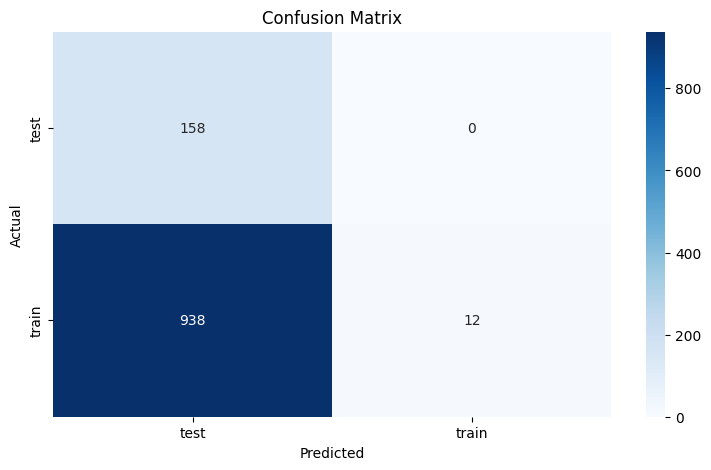

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(9, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

* The confusion matrix (confusion_matrix(y_true, y_pred)) shows correct and incorrect predictions for each class.

* Diagonal values represent correctly classified instances, while off-diagonal values indicate misclassifications.

* Uses sns.heatmap() to create a color-coded matrix, making it easier to spot patterns and errors.

* Labels (xticklabels & yticklabels) help identify misclassified categories, guiding model improvements.

* The 'Blues' colormap improves readability by highlighting high and low values effectively.

# **8: Conclusion**

1  Interpretation of Model Performance
The CNN model successfully classifies plant seedlings with reasonable accuracy.

The classification report provides precision, recall, and F1-score for each class, helping identify misclassified categories.

The confusion matrix shows the model's strength in distinguishing different seedling types, but misclassifications may exist in visually similar classes.

Overfitting risks: If training accuracy is much higher than validation accuracy, the model may be memorizing the data instead of generalizing well.

2️ Suggested Improvements & Future Enhancements

 Data Augmentation:

Increase data diversity using techniques like brightness adjustments, shearing, and elastic transformations.

Use more advanced augmentations via albumentations library.

Fine-Tuning with Pretrained Models:

Instead of training from scratch, use models like EfficientNet, ResNet50, or MobileNetV2 for improved feature extraction.

Hyperparameter Tuning:

Experiment with learning rates, batch sizes, and dropout rates to improve training efficiency.

Implement ReduceLROnPlateau to dynamically adjust learning rates.

Ensemble Learning:

Combine multiple models (e.g., CNN + SVM) for better generalization.

3️ Model Comparison & Justification
If multiple models were tested:

If computational cost matters, a custom CNN can still achieve reasonable performance.

Final Thoughts
This model provides a strong foundation for automated plant seedling classification, which can assist in agriculture and botany research.

To further enhance it:

Collect more diverse data
Use Transfer Learning
Experiment with architectures like Vision Transformers (ViTs)









